In [1]:
# Importing libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import joblib

In [51]:
data = pd.read_csv('application_train.csv')

In [2]:
prev = pd.read_csv('previous_application.csv')

In [55]:
len(data[(data['CODE_GENDER'] == 'M') & (data['TARGET'] == 1)]) / len(data[(data['CODE_GENDER'] == 'M')])

0.1014192025433328

In [56]:
len(data[(data['CODE_GENDER'] == 'F') & (data['TARGET'] == 1)]) / len(data[(data['CODE_GENDER'] == 'F')])

0.06999328222555916

In [57]:
len(data[(data['FLAG_OWN_CAR'] == 'Y') & (data['TARGET'] == 1)]) / len(data[(data['FLAG_OWN_CAR'] == 'Y')])

0.07243730100299273

In [59]:
len(data[(data['FLAG_OWN_CAR'] == 'N') & (data['TARGET'] == 1)]) / len(data[(data['FLAG_OWN_CAR'] == 'N')])

0.08500226685852831

In [62]:
len(data[(data['NAME_EDUCATION_TYPE'] == "Secondary / secondary special") & (data['TARGET'] == 1)]) / len(data[(data['NAME_EDUCATION_TYPE'] == "Secondary / secondary special")])

0.08939928843221562

In [63]:
len(data[(data['NAME_EDUCATION_TYPE'] != "Secondary / secondary special") & (data['TARGET'] == 1)]) / len(data[(data['NAME_EDUCATION_TYPE'] != "Secondary / secondary special")])

0.05948159784560143

In [64]:
len(data[(data['NAME_INCOME_TYPE'] == "Working") & (data['TARGET'] == 1)]) / len(data[(data['NAME_INCOME_TYPE'] == "Working")])

0.09588471664126369

In [65]:
len(data[(data['NAME_INCOME_TYPE'] != "Working") & (data['TARGET'] == 1)]) / len(data[(data['NAME_INCOME_TYPE'] != "Working")])

0.06455017917532288

In [20]:
train = pd.read_csv('train_home_credit.csv')

In [4]:
test = pd.read_csv('test_home_credit.csv')

In [3]:
train.shape

(246008, 122)

In [5]:
onehot = OneHotEncoder(use_cat_names=True)
ordinal = OrdinalEncoder()
imputer = SimpleImputer(strategy='most_frequent')
minmax = MinMaxScaler()

In [6]:
prev_count = prev.groupby('SK_ID_CURR').size().reset_index(name='PREV_APP_COUNT')

In [21]:
# flag == True for training
def preprocess(data, flag):
    
    if flag: # Training
        
        temp = data.drop(columns=['TARGET'])
        temp['TARGET'] = data['TARGET']

        # Preprocessing
        temp['CODE_GENDER'] = temp['CODE_GENDER'].replace('XNA', 'F')
        temp['DAYS_EMPLOYED'] = temp['DAYS_EMPLOYED'].abs()
        temp['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
        temp['DAYS_BIRTH'] = temp['DAYS_BIRTH'].abs()
        print("Done Preprocessing", len(temp), sum(temp['TARGET'].isna()))
    
    
        # Imputation
        imputed_data = imputer.fit_transform(temp)
        temp = pd.DataFrame(imputed_data, columns=temp.columns).astype(temp.dtypes.to_dict())
        print("Done Imputation", len(temp), sum(temp['TARGET'].isna()))

        
        # Ordinal Encoding
        temp.set_index('SK_ID_CURR', inplace=True)
        binary_class_cols = []
        
        for column in temp.columns:
            if (temp[column].dtype == 'object') and (len(temp[column].value_counts()) == 2): 
                binary_class_cols.append(column)
                
        encoded_data = ordinal.fit_transform(temp[binary_class_cols])
        for column in binary_class_cols:
            if column in temp.columns:
                new_column_name = column + '_original' 
                temp.rename(columns={column: new_column_name}, inplace=True)
        temp = pd.concat([temp, encoded_data], axis=1)
        print("Done Ordinal Encoding for", len(temp), sum(temp['TARGET'].isna()), binary_class_cols)

        
        # One-Hot Encoding
        encoded_data = onehot.fit_transform(temp.select_dtypes('object'))
        temp = pd.concat([temp, encoded_data], axis=1)
        print("Done One-Hot Encoding", len(temp), sum(temp['TARGET'].isna()))
        categorical_columns = temp.select_dtypes(include=['object']).columns
        print("Dropping categorical columns:",categorical_columns)
        temp.drop(categorical_columns, axis=1, inplace=True)
        
        
        # Adding new features
        temp['CREDIT_INCOME_PERCENT'] = temp['AMT_CREDIT'] / temp['AMT_INCOME_TOTAL']
        temp['ANNUITY_INCOME_PERCENT'] = temp['AMT_ANNUITY'] / temp['AMT_INCOME_TOTAL']
        temp['DAYS_EMPLOYED_PERCENT'] = temp['DAYS_EMPLOYED'] / temp['DAYS_BIRTH']
        temp = temp.merge(prev_count, on='SK_ID_CURR', how='left')
        temp['PREV_APP_COUNT'].fillna(0, inplace=True)
        
        
        # Min-Max Scaling
        temp.set_index('SK_ID_CURR', inplace=True)
        scaled_data = minmax.fit_transform(temp)
        temp = pd.DataFrame(scaled_data, columns=temp.columns, index=temp.index)
        print("Done Scaling", len(temp), sum(temp['TARGET'].isna()))
        

        if temp['TARGET'].dtype != 'int64' : temp['TARGET'] = temp['TARGET'].astype(int)
            

        
    else: # Testing
        
        temp = data.copy()
        
        # Fake target for simple imputer
        temp['TARGET'] = 0

        # Preprocessing
        temp['CODE_GENDER'] = temp['CODE_GENDER'].replace('XNA', 'F')
        temp['DAYS_EMPLOYED'] = temp['DAYS_EMPLOYED'].abs()
        temp['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
        temp['DAYS_BIRTH'] = temp['DAYS_BIRTH'].abs()
        print("Done Preprocessing")
        
    
        # Imputation
        imputed_data = imputer.transform(temp)
        temp = pd.DataFrame(imputed_data, columns=temp.columns).astype(temp.dtypes.to_dict())
        print("Done Imputation")

        
        # Ordinal Encoding
        temp.set_index('SK_ID_CURR', inplace=True)
        binary_class_cols = []
        indicies = []
        for column in temp.columns:
            if (temp[column].dtype == 'object') and (len(temp[column].value_counts()) == 2): 
                binary_class_cols.append(column)
                indicies.append(temp.columns.get_loc(column))
        encoded_data = ordinal.transform(temp[binary_class_cols])
        for column in binary_class_cols:
            if column in temp.columns:
                new_column_name = column + '_original' 
                temp.rename(columns={column: new_column_name}, inplace=True)
        temp = pd.concat([temp, encoded_data], axis=1)
        print("Done Ordinal Encoding for", len(temp), sum(temp['TARGET'].isna()), binary_class_cols)

            
        # One-Hot Encoding
        encoded_data = onehot.transform(temp.select_dtypes('object'))
        temp = pd.concat([temp, encoded_data], axis=1)
        print("Done One-Hot Encoding")
        categorical_columns = temp.select_dtypes(include=['object']).columns
        print("Dropping categorical columns:",categorical_columns)
        temp.drop(categorical_columns, axis=1, inplace=True)
        
        
        # Adding new features
        temp['CREDIT_INCOME_PERCENT'] = temp['AMT_CREDIT'] / temp['AMT_INCOME_TOTAL']
        temp['ANNUITY_INCOME_PERCENT'] = temp['AMT_ANNUITY'] / temp['AMT_INCOME_TOTAL']
        temp['DAYS_EMPLOYED_PERCENT'] = temp['DAYS_EMPLOYED'] / temp['DAYS_BIRTH']
        temp = temp.merge(prev_count, on='SK_ID_CURR', how='left')
        temp['PREV_APP_COUNT'].fillna(0, inplace=True)
        
        
        # Min-Max Scaling
        temp.set_index('SK_ID_CURR', inplace=True)
        scaled_data = minmax.transform(temp)
        temp = pd.DataFrame(scaled_data, columns=temp.columns, index=temp.index)
        print("Done Scaling")

        temp.drop(columns='TARGET', inplace=True)
        
    
    return temp

In [22]:
train = preprocess(train, True)

Done Preprocessing 246008 0
Done Imputation 246008 0
Done Ordinal Encoding for 246008 0 ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']
Done One-Hot Encoding 246008 0
Dropping categorical columns: Index(['NAME_CONTRACT_TYPE_original', 'CODE_GENDER_original',
       'FLAG_OWN_CAR_original', 'FLAG_OWN_REALTY_original', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE_original'],
      dtype='object')
Done Scaling 246008 0


In [23]:
train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,EMERGENCYSTATE_MODE_original_No,EMERGENCYSTATE_MODE_original_Yes,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,DAYS_EMPLOYED_PERCENT,PREV_APP_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
243191,0.000000,0.010787,0.127409,0.057529,0.105499,0.491595,0.894025,0.011166,0.846472,0.387523,...,0.0,0.0,0.0,0.0,1.0,0.0,0.037564,0.049330,0.011753,0.097222
111778,0.052632,0.009785,0.038224,0.085890,0.032548,0.134897,0.193461,0.006532,0.817176,0.527720,...,0.0,0.0,0.0,0.0,1.0,0.0,0.014067,0.078367,0.014700,0.055556
175057,0.000000,0.008115,0.182598,0.091874,0.151515,0.491595,0.886359,0.120422,0.757431,0.304016,...,0.0,0.0,0.0,0.0,1.0,0.0,0.067128,0.097795,0.127498,0.250000
372147,0.052632,0.010278,0.213483,0.137171,0.214366,0.421848,0.181172,0.141246,0.888196,0.617757,...,0.0,0.0,0.0,0.0,1.0,0.0,0.063974,0.117908,0.324339,0.208333
373412,0.000000,0.014795,0.122015,0.076746,0.108866,0.344429,0.468377,0.196516,0.658097,0.305127,...,0.0,0.0,0.0,0.0,1.0,0.0,0.027226,0.048758,0.305721,0.041667


In [24]:
target = 'TARGET'
X_train = train.drop(columns = target)
y_train = train[target]
X_test = test.drop(columns = target)
y_test = test[target]

In [25]:
X_test = preprocess(X_test, False)

Done Preprocessing
Done Imputation
Done Ordinal Encoding for 61503 0 ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']
Done One-Hot Encoding
Dropping categorical columns: Index(['NAME_CONTRACT_TYPE_original', 'CODE_GENDER_original',
       'FLAG_OWN_CAR_original', 'FLAG_OWN_REALTY_original', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE_original'],
      dtype='object')
Done Scaling


In [17]:
X_test.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,EMERGENCYSTATE_MODE_original_No,EMERGENCYSTATE_MODE_original_Yes,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,DAYS_EMPLOYED_PERCENT,PREV_APP_COUNT
0,0.798794,0.105263,0.013459,0.104983,0.199000,0.094276,0.129331,0.327396,0.042541,0.972796,...,0.0,0.0,0.0,0.0,1.0,0.0,0.025770,0.134020,0.078630,0.069444
1,0.320018,0.000000,0.016465,0.308792,0.184591,0.283951,0.090864,0.410879,0.063700,0.931244,...,0.0,0.0,1.0,0.0,1.0,0.0,0.060375,0.103827,0.105939,0.166667
2,0.118537,0.000000,0.013125,0.112360,0.146227,0.113356,0.491595,0.587260,0.035674,0.892936,...,0.0,0.0,0.0,0.0,1.0,0.0,0.028083,0.101355,0.048962,0.097222
3,0.811695,0.000000,0.016465,0.052360,0.090962,0.046016,0.635991,0.684160,0.389795,0.523104,...,0.0,0.0,0.0,0.0,1.0,0.0,0.011367,0.052029,0.488127,0.013889
4,0.515405,0.000000,0.006446,0.065701,0.055563,0.048260,0.257000,0.723675,0.061690,0.688290,...,0.0,0.0,0.0,0.0,1.0,0.0,0.031561,0.073515,0.074589,0.125000


In [26]:
def feature_selection(X_train, y_train, X_test, y_test, selected_features, features, threshold):
    
    lr = LogisticRegression(C = 0.01, random_state=42)
    lr.fit(X_train[selected_features], y_train)
    test_pred = lr.predict_proba(X_test[selected_features])[:, 1]
    auroc_base = roc_auc_score(y_test, test_pred)
    
    for feature in features:
        
        candidate_features = selected_features + [feature]
        lr.fit(X_train[candidate_features], y_train)

        test_pred = lr.predict_proba(X_test[candidate_features])[:, 1]
        auroc_test = roc_auc_score(y_test, test_pred)

        if (auroc_test - auroc_base) > threshold:
            auroc_base = auroc_test
            selected_features.append(feature)
            print("AUROC: ", auroc_base, "Added: ", feature)
        
        print(feature,"done")

In [27]:
selected_features = ['CODE_GENDER', 'DAYS_BIRTH', 'DAYS_EMPLOYED','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [28]:
features = X_train.drop(columns=selected_features)

In [29]:
features

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,EMERGENCYSTATE_MODE_original_No,EMERGENCYSTATE_MODE_original_Yes,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,DAYS_EMPLOYED_PERCENT,PREV_APP_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
243191,0.000000,0.010787,0.127409,0.057529,0.105499,0.491595,0.846472,0.387523,0.340659,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.037564,0.049330,0.011753,0.097222
111778,0.052632,0.009785,0.038224,0.085890,0.032548,0.134897,0.817176,0.527720,0.076923,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.014067,0.078367,0.014700,0.055556
175057,0.000000,0.008115,0.182598,0.091874,0.151515,0.491595,0.757431,0.304016,0.087912,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.067128,0.097795,0.127498,0.250000
372147,0.052632,0.010278,0.213483,0.137171,0.214366,0.421848,0.888196,0.617757,0.164835,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.063974,0.117908,0.324339,0.208333
373412,0.000000,0.014795,0.122015,0.076746,0.108866,0.344429,0.658097,0.305127,0.076923,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.027226,0.048758,0.305721,0.041667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239009,0.000000,0.007114,0.157303,0.120849,0.158249,0.083289,0.837163,0.425594,0.076923,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.064827,0.141512,0.106501,0.027778
399937,0.105263,0.014795,0.116085,0.151334,0.107744,0.038481,0.931115,0.379603,0.076923,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.025979,0.094149,0.025862,0.125000
253016,0.000000,0.031493,0.269663,0.122499,0.270483,0.197042,0.784848,0.288176,0.010989,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.028739,0.037411,0.568535,0.055556


In [30]:
# Difference 0.0001
feature_selection(X_train, y_train, X_test, y_test, selected_features, features, 0.0001)

CNT_CHILDREN done
AMT_INCOME_TOTAL done
AMT_CREDIT done
AMT_ANNUITY done
AMT_GOODS_PRICE done
AUROC:  0.7166107415845321 Added:  REGION_POPULATION_RELATIVE
REGION_POPULATION_RELATIVE done
AUROC:  0.7167755016720287 Added:  DAYS_REGISTRATION
DAYS_REGISTRATION done
AUROC:  0.7180186625152394 Added:  DAYS_ID_PUBLISH
DAYS_ID_PUBLISH done
OWN_CAR_AGE done
FLAG_MOBIL done
AUROC:  0.7197757044762116 Added:  FLAG_EMP_PHONE
FLAG_EMP_PHONE done
FLAG_WORK_PHONE done
FLAG_CONT_MOBILE done
AUROC:  0.7201200557030153 Added:  FLAG_PHONE
FLAG_PHONE done
AUROC:  0.7203241211147637 Added:  FLAG_EMAIL
FLAG_EMAIL done
CNT_FAM_MEMBERS done
AUROC:  0.7207946524007691 Added:  REGION_RATING_CLIENT
REGION_RATING_CLIENT done
REGION_RATING_CLIENT_W_CITY done
AUROC:  0.7209824325959064 Added:  HOUR_APPR_PROCESS_START
HOUR_APPR_PROCESS_START done
REG_REGION_NOT_LIVE_REGION done
REG_REGION_NOT_WORK_REGION done
LIVE_REGION_NOT_WORK_REGION done
AUROC:  0.7212360610890132 Added:  REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_LI

In [31]:
len(selected_features)

46

In [29]:
selected_features

['CODE_GENDER',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'HOUR_APPR_PROCESS_START',
 'REG_CITY_NOT_LIVE_CITY',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'ELEVATORS_AVG',
 'FLOORSMAX_AVG',
 'LIVINGAREA_AVG',
 'TOTALAREA_MODE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_18',
 'NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE_Unaccompanied',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_Working',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_State servant',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_FAMILY_STATUS_Married',
 'NAME_HOUSING_TYPE_House / apartment',
 'OCCUPATION_TYPE_Drivers',
 'OCCUPATION_TYPE_Sales staff',
 'OCCUPATION_TYPE_Core staff',
 'WEEKDA

In [9]:
selected_features = ['CODE_GENDER',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'HOUR_APPR_PROCESS_START',
 'REG_CITY_NOT_LIVE_CITY',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'ELEVATORS_AVG',
 'FLOORSMAX_AVG',
 'LIVINGAREA_AVG',
 'TOTALAREA_MODE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_18',
 'NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE_Unaccompanied',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_Working',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_State servant',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_FAMILY_STATUS_Married',
 'NAME_HOUSING_TYPE_House / apartment',
 'OCCUPATION_TYPE_Drivers',
 'OCCUPATION_TYPE_Sales staff',
 'OCCUPATION_TYPE_Core staff',
 'WEEKDAY_APPR_PROCESS_START_TUESDAY',
 'ORGANIZATION_TYPE_Self-employed',
 'ORGANIZATION_TYPE_Industry: type 9',
 'DAYS_EMPLOYED_PERCENT']

In [32]:
selected_features2 = ['CODE_GENDER', 'DAYS_BIRTH', 'DAYS_EMPLOYED','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [33]:
# Difference 0.001
feature_selection(X_train, y_train, X_test, y_test, selected_features2, features, 0.001)

CNT_CHILDREN done
AMT_INCOME_TOTAL done
AMT_CREDIT done
AMT_ANNUITY done
AMT_GOODS_PRICE done
REGION_POPULATION_RELATIVE done
DAYS_REGISTRATION done
AUROC:  0.7175322318843632 Added:  DAYS_ID_PUBLISH
DAYS_ID_PUBLISH done
OWN_CAR_AGE done
FLAG_MOBIL done
AUROC:  0.71930808866558 Added:  FLAG_EMP_PHONE
FLAG_EMP_PHONE done
FLAG_WORK_PHONE done
FLAG_CONT_MOBILE done
FLAG_PHONE done
FLAG_EMAIL done
CNT_FAM_MEMBERS done
REGION_RATING_CLIENT done
REGION_RATING_CLIENT_W_CITY done
HOUR_APPR_PROCESS_START done
REG_REGION_NOT_LIVE_REGION done
REG_REGION_NOT_WORK_REGION done
LIVE_REGION_NOT_WORK_REGION done
REG_CITY_NOT_LIVE_CITY done
REG_CITY_NOT_WORK_CITY done
LIVE_CITY_NOT_WORK_CITY done
APARTMENTS_AVG done
BASEMENTAREA_AVG done
YEARS_BEGINEXPLUATATION_AVG done
YEARS_BUILD_AVG done
COMMONAREA_AVG done
ELEVATORS_AVG done
ENTRANCES_AVG done
AUROC:  0.7203960647570813 Added:  FLOORSMAX_AVG
FLOORSMAX_AVG done
FLOORSMIN_AVG done
LANDAREA_AVG done
LIVINGAPARTMENTS_AVG done
LIVINGAREA_AVG done
NONLIVI

In [34]:
len(selected_features2)

13

In [33]:
selected_features2

['CODE_GENDER',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'FLAG_OWN_CAR',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'DAYS_EMPLOYED_PERCENT']

In [35]:
common = [value for value in selected_features2 if value in selected_features]

In [36]:
common

['CODE_GENDER',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'FLAG_OWN_CAR',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'DAYS_EMPLOYED_PERCENT']

In [86]:
X_train.to_csv('HC_Xtrain_preprocessed_all.csv', index=True)
X_train[selected_features].to_csv('HC_Xtrain_preprocessed_43.csv', index=True)
X_train[selected_features2].to_csv('HC_Xtrain_preprocessed_13.csv', index=True)
y_train.to_csv('HC_ytrain.csv', index=True)

In [87]:
X_test.to_csv('HC_Xtest_preprocessed_all.csv', index=True)
X_test[selected_features].to_csv('HC_Xtest_preprocessed_43.csv', index=True)
X_test[selected_features2].to_csv('HC_Xtest_preprocessed_13.csv', index=True)
y_test.to_csv('HC_ytest.csv', index=True)

## Logistic Regression

In [35]:
lr = LogisticRegression(C = 0.01, random_state=42, class_weight='balanced')

In [36]:
lr.fit(X_train[selected_features], y_train)

LogisticRegression(C=0.01, class_weight='balanced', random_state=42)

In [37]:
train_pred = lr.predict_proba(X_train[selected_features])[:, 1]
auroc_train = roc_auc_score(y_train, train_pred)
auroc_train

0.7339504627984182

In [38]:
test_pred = lr.predict_proba(X_test[selected_features])[:, 1]
auroc_test = roc_auc_score(y_test, test_pred)
auroc_test

0.7382020662102599

In [39]:
joblib.dump(lr, 'Logistic_Reg_HC.pkl')

['Logistic_Reg_HC.pkl']

## Random Forest

In [40]:
rf = RandomForestClassifier(n_estimators=150, max_depth=8, max_features='sqrt', 
                            class_weight='balanced', random_state=42)

In [41]:
rf.fit(X_train[selected_features], y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=150,
                       random_state=42)

In [42]:
train_pred = rf.predict_proba(X_train[selected_features])[:, 1]
auroc_train = roc_auc_score(y_train, train_pred)
auroc_train

0.7587356870944539

In [43]:
test_pred = rf.predict_proba(X_test[selected_features])[:, 1]
auroc_test = roc_auc_score(y_test, test_pred)
auroc_test

0.7368227605274331

In [44]:
joblib.dump(rf, 'Random_Forest_HC.pkl')

['Random_Forest_HC.pkl']

In [60]:
depth_hyperparams = range(2,16,2)

In [61]:
# Create empty lists for training and validation accuracy scores
training_auroc = []
validation_auroc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = RandomForestClassifier(n_estimators=100, max_depth=d, random_state=42)
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_auroc`
    training_auroc.append(roc_auc_score(y_train, test_model.predict_proba(X_train)[:, 1]))
    # Calculate validation accuracy score and append to `validation_auroc`
    validation_auroc.append(roc_auc_score(y_test, test_model.predict_proba(X_test)[:, 1]))
    print('done',d)

done 2
done 4
done 6
done 8
done 10
done 12
done 14


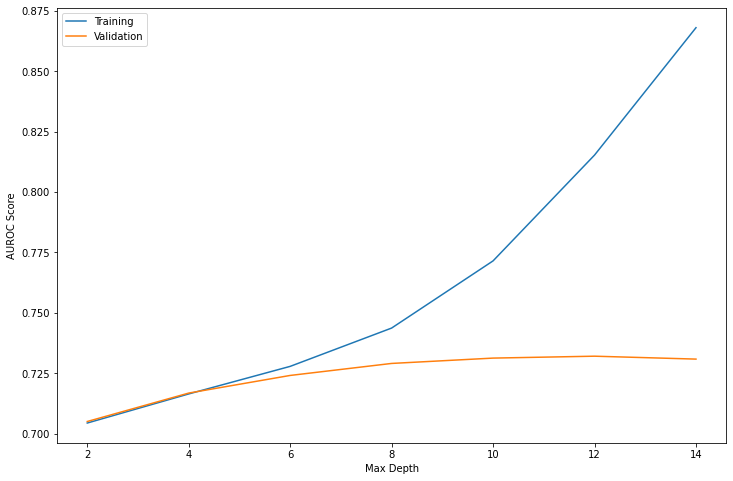

In [62]:
plt.figure(figsize=(12,8))
plt.plot(depth_hyperparams, training_auroc, label="Training")
plt.plot(depth_hyperparams, validation_auroc, label="Validation")
plt.xlabel("Max Depth")
plt.ylabel("AUROC Score")
plt.legend();

In [45]:
features = X_train[selected_features].columns
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values()

In [46]:
feat_imp

FLAG_DOCUMENT_13                                     0.000086
ORGANIZATION_TYPE_Industry: type 9                   0.000207
FLAG_DOCUMENT_18                                     0.000238
ORGANIZATION_TYPE_Transport: type 3                  0.000259
FLAG_DOCUMENT_5                                      0.000301
FLAG_DOCUMENT_16                                     0.000337
ORGANIZATION_TYPE_Military                           0.000349
NAME_HOUSING_TYPE_Municipal apartment                0.000477
WEEKDAY_APPR_PROCESS_START_TUESDAY                   0.000513
FLAG_EMAIL                                           0.000555
NAME_EDUCATION_TYPE_Lower secondary                  0.000600
FLAG_DOCUMENT_8                                      0.000864
OCCUPATION_TYPE_Sales staff                          0.001073
NAME_INCOME_TYPE_Commercial associate                0.001125
FLAG_PHONE                                           0.001214
OCCUPATION_TYPE_Drivers                              0.001394
FLAG_DOC

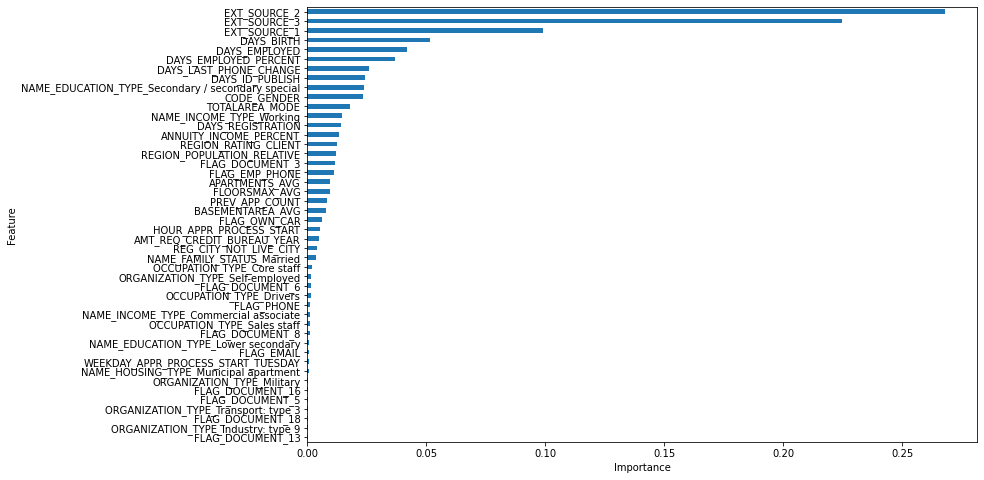

In [47]:
plt.figure(figsize=(12,8))
feat_imp.plot(kind="barh")
plt.xlabel("Importance")
plt.ylabel("Feature");

## Gradient Boosting

In [60]:
gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=4,
                                 max_features='sqrt', random_state=42, subsample=0.8)

In [61]:
gbc.fit(X_train[selected_features], y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=4, max_features='sqrt',
                           n_estimators=200, random_state=42, subsample=0.8)

In [62]:
train_pred = gbc.predict_proba(X_train[selected_features])[:, 1]
auroc_train = roc_auc_score(y_train, train_pred)
auroc_train

0.7575198860337556

In [63]:
test_pred = gbc.predict_proba(X_test[selected_features])[:, 1]
auroc_test = roc_auc_score(y_test, test_pred)
auroc_test

0.7496722180342832

In [64]:
joblib.dump(gbc, 'Gradient_Boosting_HC.pkl')

['Gradient_Boosting_HC.pkl']

In [83]:
depth_hyperparams = range(2,10,2)

In [84]:
# Create empty lists for training and validation accuracy scores
training_auroc = []
validation_auroc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=d, random_state=42)
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_auroc`
    training_auroc.append(roc_auc_score(y_train, test_model.predict_proba(X_train)[:, 1]))
    # Calculate validation accuracy score and append to `validation_auroc`
    validation_auroc.append(roc_auc_score(y_test, test_model.predict_proba(X_test)[:, 1]))
    print('done',d)

done 2
done 4
done 6
done 8


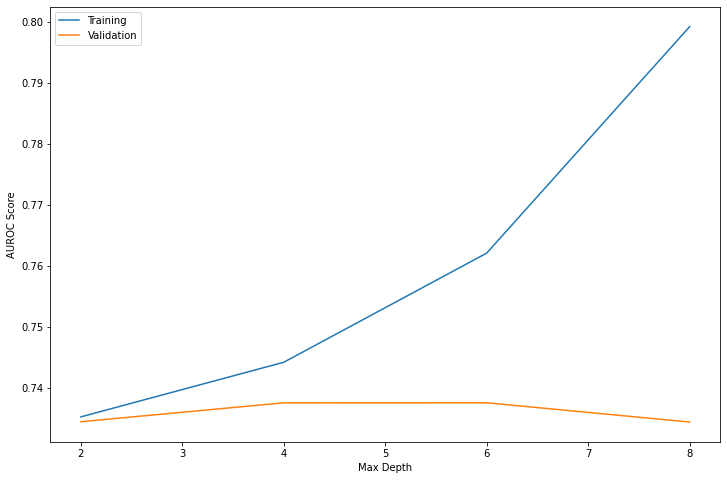

In [85]:
plt.figure(figsize=(12,8))
plt.plot(depth_hyperparams, training_auroc, label="Training")
plt.plot(depth_hyperparams, validation_auroc, label="Validation")
plt.xlabel("Max Depth")
plt.ylabel("AUROC Score")
plt.legend();

In [87]:
lr_hyperparams = np.arange(0.2, 1.2, 0.2)

In [88]:
# Create empty lists for training and validation accuracy scores
training_auroc = []
validation_auroc = []

for lr in lr_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = GradientBoostingClassifier(n_estimators=100, learning_rate=lr, max_depth=3, random_state=42)
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_auroc`
    training_auroc.append(roc_auc_score(y_train, test_model.predict_proba(X_train)[:, 1]))
    # Calculate validation accuracy score and append to `validation_auroc`
    validation_auroc.append(roc_auc_score(y_test, test_model.predict_proba(X_test)[:, 1]))
    print('done',lr)

done 0.2
done 0.4
done 0.6000000000000001
done 0.8
done 1.0


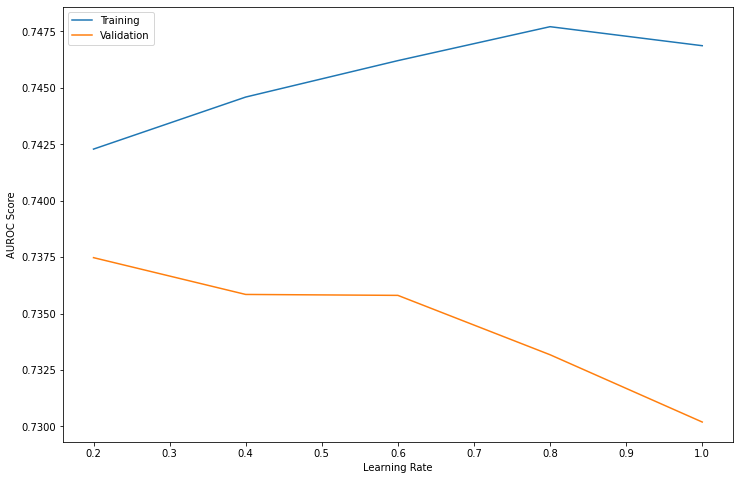

In [89]:
plt.figure(figsize=(12,8))
plt.plot(lr_hyperparams, training_auroc, label="Training")
plt.plot(lr_hyperparams, validation_auroc, label="Validation")
plt.xlabel("Learning Rate")
plt.ylabel("AUROC Score")
plt.legend();

## XGBoost

In [52]:
xgb = XGBClassifier(objective ='binary:logistic', n_estimators=300, max_depth=4, 
                    eval_metric=roc_auc_score, learning_rate=0.1, subsample=0.9)

In [53]:
# 43 features
xgb.fit(X_train[selected_features], y_train, eval_set=[(X_test[selected_features],y_test)])

[0]	validation_0-logloss:0.62497	validation_0-roc_auc_score:0.69213
[1]	validation_0-logloss:0.56923	validation_0-roc_auc_score:0.69522
[2]	validation_0-logloss:0.52305	validation_0-roc_auc_score:0.70237
[3]	validation_0-logloss:0.48443	validation_0-roc_auc_score:0.70445
[4]	validation_0-logloss:0.45187	validation_0-roc_auc_score:0.70563
[5]	validation_0-logloss:0.42425	validation_0-roc_auc_score:0.70690
[6]	validation_0-logloss:0.40067	validation_0-roc_auc_score:0.70879
[7]	validation_0-logloss:0.38051	validation_0-roc_auc_score:0.70892
[8]	validation_0-logloss:0.36323	validation_0-roc_auc_score:0.70993
[9]	validation_0-logloss:0.34834	validation_0-roc_auc_score:0.71073
[10]	validation_0-logloss:0.33555	validation_0-roc_auc_score:0.71182
[11]	validation_0-logloss:0.32449	validation_0-roc_auc_score:0.71237
[12]	validation_0-logloss:0.31499	validation_0-roc_auc_score:0.71226
[13]	validation_0-logloss:0.30674	validation_0-roc_auc_score:0.71361
[14]	validation_0-logloss:0.29953	validation

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function roc_auc_score at 0x0000014D02247940>,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [54]:
train_pred = xgb.predict_proba(X_train[selected_features])[:, 1]
auroc_train = roc_auc_score(y_train, train_pred)
auroc_train

0.7826815251694925

In [55]:
test_pred = xgb.predict_proba(X_test[selected_features])[:, 1]
auroc_test = roc_auc_score(y_test, test_pred)
auroc_test

0.7536150822771803

In [56]:
joblib.dump(xgb, 'XGB_HC.pkl')

['XGB_HC.pkl']

In [102]:
depth_hyperparams = range(2,10,2)

In [103]:
# Create empty lists for training and validation accuracy scores
training_auroc = []
validation_auroc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = XGBClassifier(objective ='binary:logistic', n_estimators= 100, max_depth=d, learning_rate=0.1, subsample=0.8)
    # Fit model to training data
    test_model.fit(X_train[selected_features], y_train)
    # Calculate training accuracy score and append to `training_auroc`
    training_auroc.append(roc_auc_score(y_train, test_model.predict_proba(X_train[selected_features])[:, 1]))
    # Calculate validation accuracy score and append to `validation_auroc`
    validation_auroc.append(roc_auc_score(y_test, test_model.predict_proba(X_test[selected_features])[:, 1]))
    print('done',d)

done 2
done 4
done 6
done 8


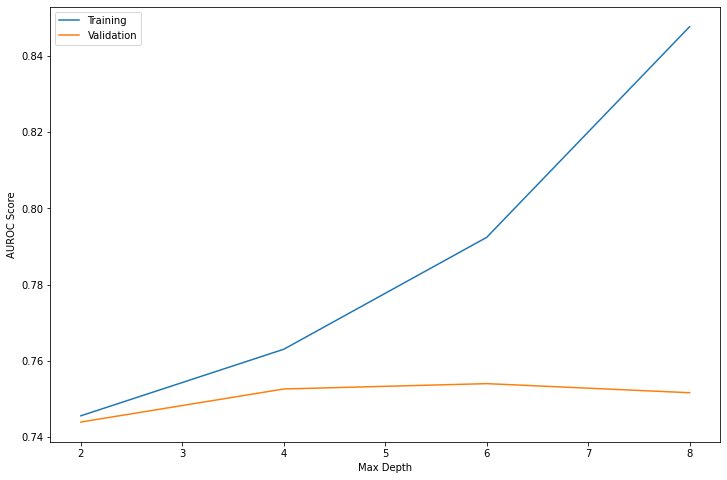

In [104]:
plt.figure(figsize=(12,8))
plt.plot(depth_hyperparams, training_auroc, label="Training")
plt.plot(depth_hyperparams, validation_auroc, label="Validation")
plt.xlabel("Max Depth")
plt.ylabel("AUROC Score")
plt.legend();

In [109]:
lr_hyperparams = np.arange(0.02, 0.12, 0.02)

In [111]:
# Create empty lists for training and validation accuracy scores
training_auroc = []
validation_auroc = []

for lr in lr_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = XGBClassifier(objective ='binary:logistic', n_estimators= 100, max_depth=4, learning_rate=lr, subsample=0.8)
    # Fit model to training data
    test_model.fit(X_train[selected_features], y_train)
    # Calculate training accuracy score and append to `training_auroc`
    training_auroc.append(roc_auc_score(y_train, test_model.predict_proba(X_train[selected_features])[:, 1]))
    # Calculate validation accuracy score and append to `validation_auroc`
    validation_auroc.append(roc_auc_score(y_test, test_model.predict_proba(X_test[selected_features])[:, 1]))
    print('done',lr)

done 0.02
done 0.04
done 0.06
done 0.08
done 0.1


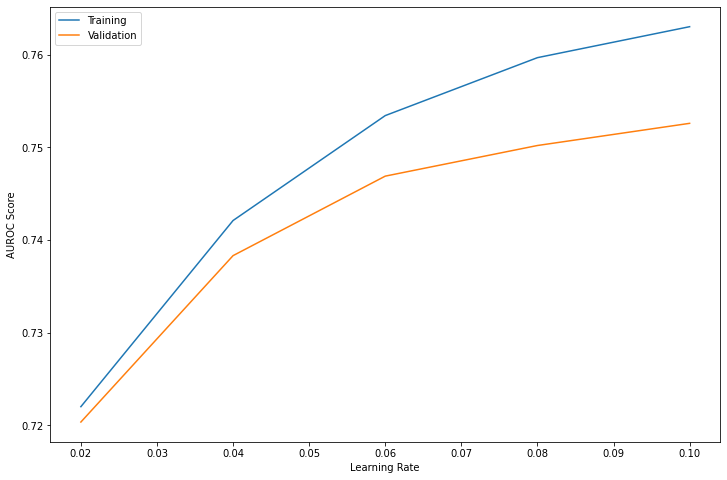

In [112]:
plt.figure(figsize=(12,8))
plt.plot(lr_hyperparams, training_auroc, label="Training")
plt.plot(lr_hyperparams, validation_auroc, label="Validation")
plt.xlabel("Learning Rate")
plt.ylabel("AUROC Score")
plt.legend();

In [57]:
features = X_train[selected_features].columns
importances = xgb.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values()

In [58]:
feat_imp

NAME_INCOME_TYPE_Commercial associate                0.005752
FLAG_EMAIL                                           0.007445
FLAG_DOCUMENT_6                                      0.007513
WEEKDAY_APPR_PROCESS_START_TUESDAY                   0.007964
HOUR_APPR_PROCESS_START                              0.008083
FLAG_DOCUMENT_5                                      0.008156
FLAG_DOCUMENT_13                                     0.008843
BASEMENTAREA_AVG                                     0.008933
NAME_HOUSING_TYPE_Municipal apartment                0.009580
APARTMENTS_AVG                                       0.009922
OCCUPATION_TYPE_Sales staff                          0.009952
REGION_POPULATION_RELATIVE                           0.010197
ORGANIZATION_TYPE_Industry: type 9                   0.010400
DAYS_REGISTRATION                                    0.010488
FLAG_PHONE                                           0.010814
FLOORSMAX_AVG                                        0.012128
FLAG_DOC

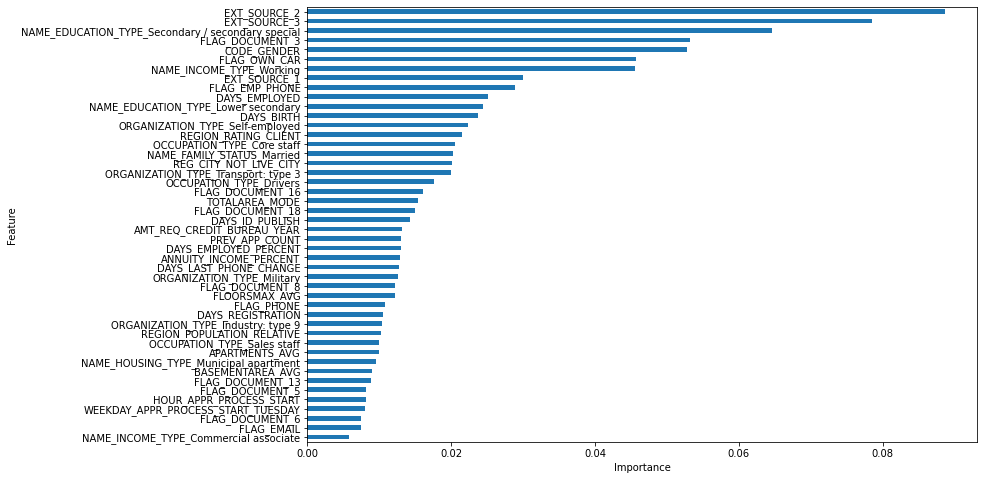

In [59]:
plt.figure(figsize=(12,8))
feat_imp.plot(kind="barh")
plt.xlabel("Importance")
plt.ylabel("Feature");

## Kaggle Testing

In [65]:
kaggle_test = pd.read_csv('application_test.csv')

In [66]:
kaggle_test = preprocess(kaggle_test, False)

Done Preprocessing
Done Imputation
Done Ordinal Encoding for 48744 0 ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']
Done One-Hot Encoding
Dropping categorical columns: Index(['NAME_CONTRACT_TYPE_original', 'CODE_GENDER_original',
       'FLAG_OWN_CAR_original', 'FLAG_OWN_REALTY_original', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE_original'],
      dtype='object')
Done Scaling


In [67]:
kaggle_test.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,EMERGENCYSTATE_MODE_original_No,EMERGENCYSTATE_MODE_original_Yes,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,DAYS_EMPLOYED_PERCENT,PREV_APP_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.000000,0.008115,0.130787,0.073886,0.102132,0.257000,0.662458,0.130025,0.779211,0.887175,...,0.0,0.0,0.0,0.0,1.0,0.0,0.048974,0.079549,0.166084,0.013889
100005,0.000000,0.005444,0.044387,0.061443,0.034792,0.491595,0.596110,0.249498,0.610608,0.774489,...,0.0,0.0,0.0,0.0,1.0,0.0,0.025788,0.091914,0.339454,0.027778
100013,0.000000,0.013125,0.154373,0.265830,0.147026,0.260475,0.707384,0.248883,0.907115,0.513269,...,0.0,0.0,0.0,0.0,1.0,0.0,0.037897,0.182227,0.305260,0.055556
100028,0.105263,0.021474,0.382022,0.184872,0.382716,0.361433,0.365671,0.104176,0.914588,0.415312,...,0.0,0.0,0.0,0.0,1.0,0.0,0.058265,0.081319,0.183195,0.069444
100038,0.052632,0.011455,0.144944,0.118761,0.145903,0.134897,0.312909,0.122320,0.829177,0.407809,...,0.0,0.0,0.0,0.0,1.0,0.0,0.040254,0.093353,0.230542,0.027778


In [68]:
temp = kaggle_test.copy()

In [69]:
lr_test = lr.predict_proba(temp[selected_features])[:, 1]
kaggle_test['lr'] = lr_test

In [70]:
rf_test = rf.predict_proba(temp[selected_features])[:, 1]
kaggle_test['rf'] = rf_test

In [71]:
gbc_test = gbc.predict_proba(temp[selected_features])[:, 1]
kaggle_test['gbc'] = gbc_test

In [72]:
xgb_test = xgb.predict_proba(temp[selected_features])[:, 1]
kaggle_test['xgb'] = xgb_test

In [73]:
kaggle_test.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,EMERGENCYSTATE_MODE_original_No,EMERGENCYSTATE_MODE_original_Yes,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,DAYS_EMPLOYED_PERCENT,PREV_APP_COUNT,lr,rf,gbc,xgb
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.000000,0.008115,0.130787,0.073886,0.102132,0.257000,0.662458,0.130025,0.779211,0.887175,...,1.0,0.0,0.048974,0.079549,0.166084,0.013889,0.357143,0.391755,0.043557,0.029919
100005,0.000000,0.005444,0.044387,0.061443,0.034792,0.491595,0.596110,0.249498,0.610608,0.774489,...,1.0,0.0,0.025788,0.091914,0.339454,0.027778,0.698198,0.492954,0.117943,0.140710
100013,0.000000,0.013125,0.154373,0.265830,0.147026,0.260475,0.707384,0.248883,0.907115,0.513269,...,1.0,0.0,0.037897,0.182227,0.305260,0.055556,0.336906,0.341062,0.035853,0.039939
100028,0.105263,0.021474,0.382022,0.184872,0.382716,0.361433,0.365671,0.104176,0.914588,0.415312,...,1.0,0.0,0.058265,0.081319,0.183195,0.069444,0.352459,0.365400,0.040403,0.038300
100038,0.052632,0.011455,0.144944,0.118761,0.145903,0.134897,0.312909,0.122320,0.829177,0.407809,...,1.0,0.0,0.040254,0.093353,0.230542,0.027778,0.531756,0.585867,0.095656,0.130015


In [74]:
lr_sub = kaggle_test[['lr']]
rf_sub = kaggle_test[['rf']]
gbc_sub = kaggle_test[['gbc']]
xgb_sub = kaggle_test[['xgb']]

In [75]:
lr_sub.rename(columns={'lr': 'TARGET'}, inplace=True)
rf_sub.rename(columns={'rf': 'TARGET'}, inplace=True)
gbc_sub.rename(columns={'gbc': 'TARGET'}, inplace=True)
xgb_sub.rename(columns={'xgb': 'TARGET'}, inplace=True)

In [76]:
lr_sub.to_csv('HC_lr_sub_finall.csv', index=True)
rf_sub.to_csv('HC_rf_sub_finall.csv', index=True)
gbc_sub.to_csv('HC_gbc_sub_finall.csv', index=True)
xgb_sub.to_csv('HC_xgb_sub_finall.csv', index=True)